In [1]:
import tensorflow as tf

2025-03-05 12:37:34.902937: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-05 12:37:35.129944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-05 12:37:35.225679: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-05 12:37:35.252595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-05 12:37:35.410702: I tensorflow/core/platform/cpu_feature_guar

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import keras
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

In [4]:
x_val, y_val = x_train[-10000:], y_train[-10000:]
x_train, y_train = x_train[:-10000], y_train[:-10000]

In [5]:
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

train_counts = np.bincount(y_train, minlength=10)
valid_counts = np.bincount(y_val, minlength=10)
test_counts = np.bincount(y_test, minlength=10)

df = pd.DataFrame(
    {"Train": train_counts, "Validation": valid_counts, "Test": test_counts},
    index=class_names
)

df = df.sort_index()
print(df)

             Train  Validation  Test
Ankle boot    4979        1021  1000
Bag           5032         968  1000
Coat          4950        1050  1000
Dress         4979        1021  1000
Pullover      4992        1008  1000
Sandal        5004         996  1000
Shirt         5030         970  1000
Sneaker       5045         955  1000
T-shirt/top   4977        1023  1000
Trouser       5012         988  1000


In [6]:
print("Range of training set:", np.min(x_train), "-", np.max(x_train))
print("Range of test set:", np.min(x_test), "-", np.max(x_test))
print("Range of validation set:", np.min(x_val), "-", np.max(x_val))

Range of training set: 0 - 255
Range of test set: 0 - 255
Range of validation set: 0 - 255


We can see that the maximum value for all sets is 255, so we scale them by dividing each of them with 255.

In [7]:
x_train, x_test, x_val = x_train / 255., x_test / 255., x_val/255.

In [8]:
def split_images(dataset):
    top_half = dataset[:, :14, :]  
    bottom_half = dataset[:, 14:, :]
    return top_half, bottom_half

x_train_top, x_train_bottom = split_images(x_train)
x_val_top, x_val_bottom = split_images(x_val)
x_test_top, x_test_bottom = split_images(x_test)

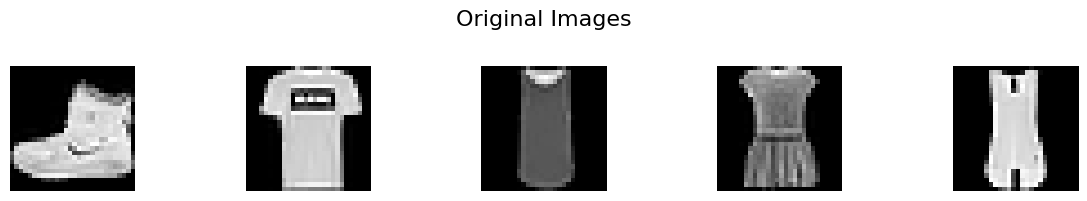

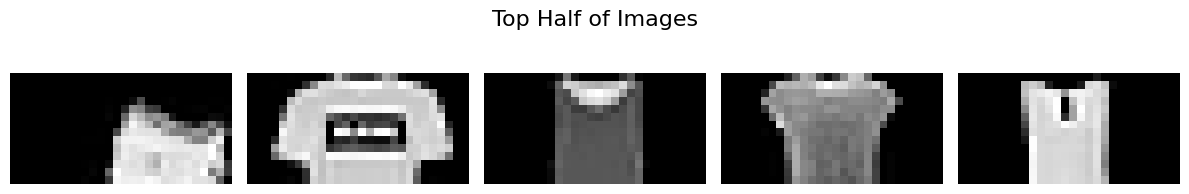

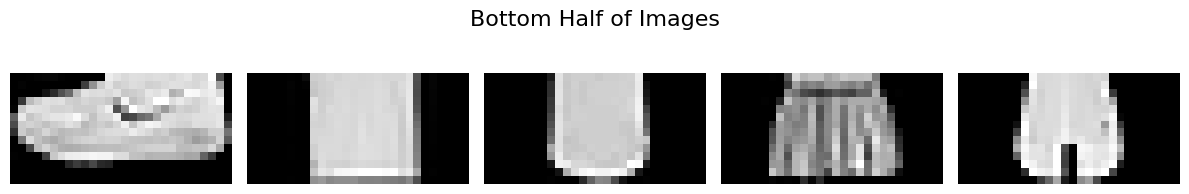

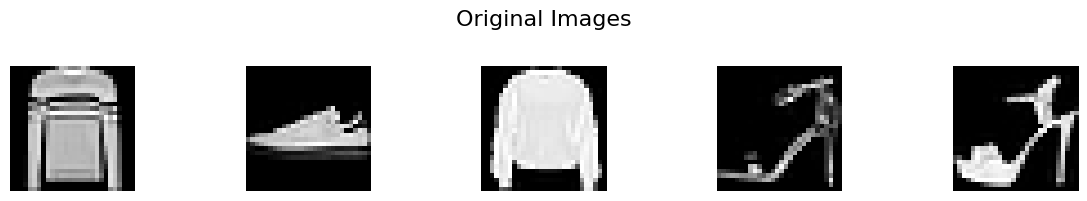

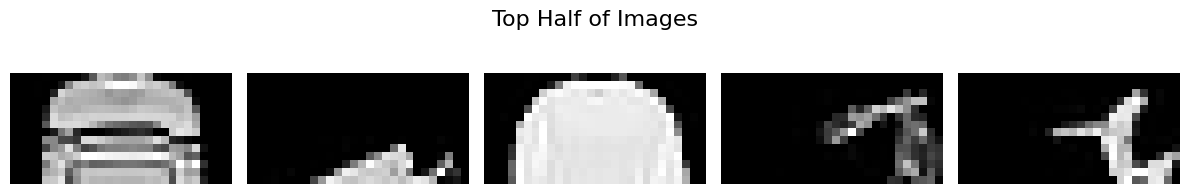

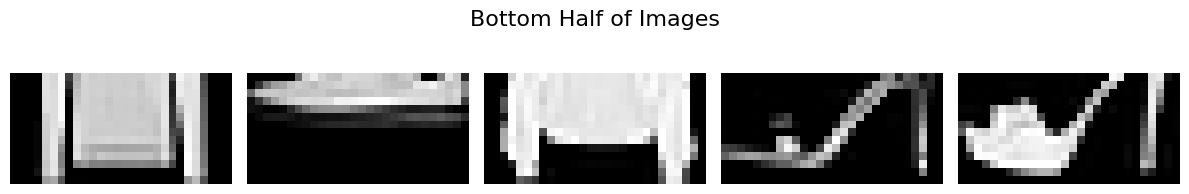

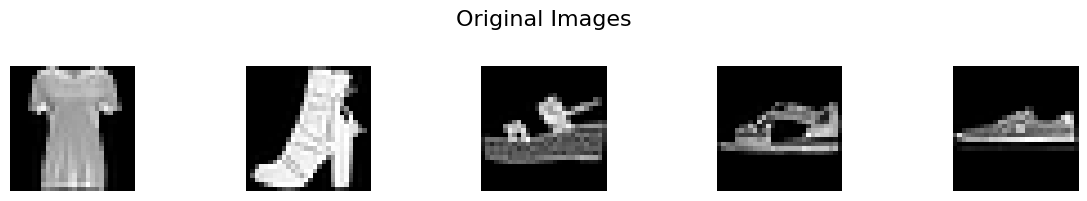

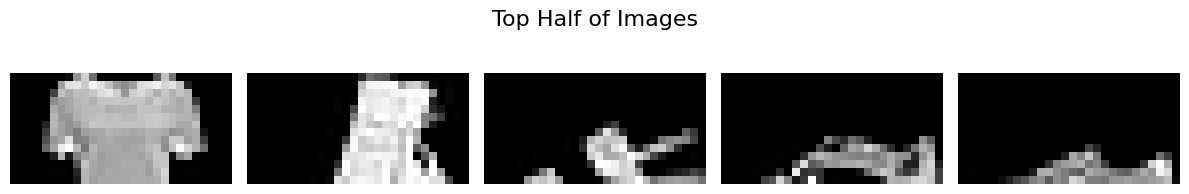

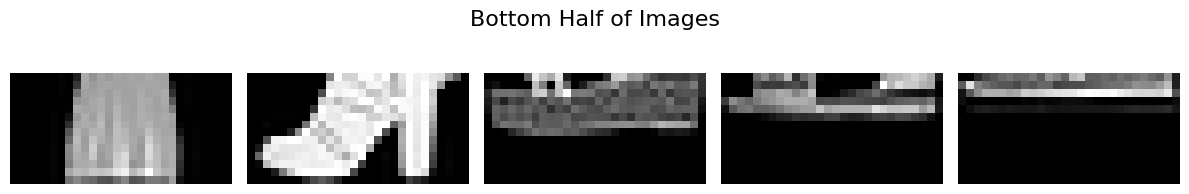

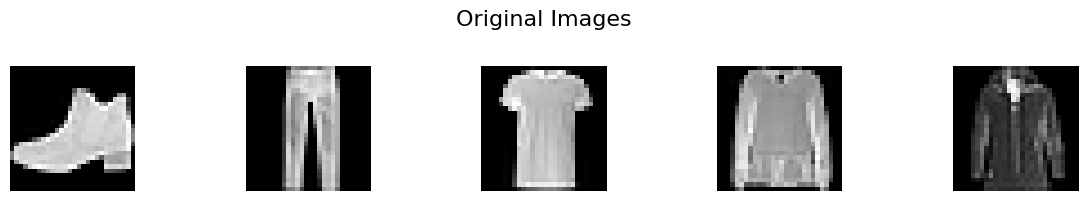

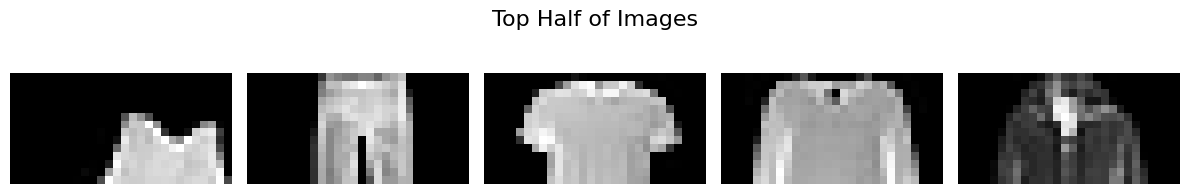

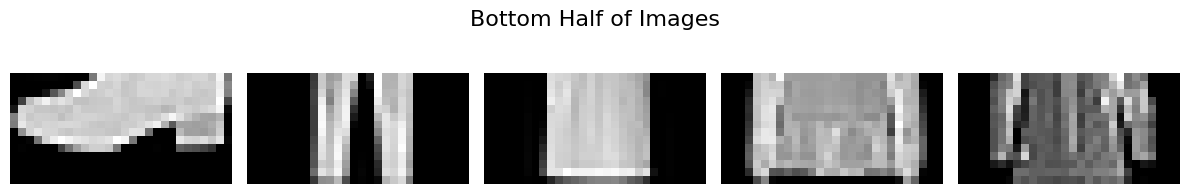

In [9]:
def plot_images(images, title):
    fig, axes = plt.subplots(1, 5, figsize=(12, 2))
    fig.suptitle(title, fontsize=16)
    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap="gray")
        ax.axis("off")
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()
    print("\n\n")
    

for j, i in zip([0, 5, 10, 15], [5, 10, 15, 20]):
    plot_images(x_train[j:i], "Original Images")
    plot_images(x_train_top[j:i], "Top Half of Images")
    plot_images(x_train_bottom[j:i], "Bottom Half of Images")
    print("\n")

From the images above, we can confirm that each instance has been correctly split into its top and bottom half.

In [10]:
tf.random.set_seed(42)
model1 = tf.keras.Sequential()
model1.add(tf.keras.layers.Flatten(input_shape=[14, 28]))
model1.add(tf.keras.layers.Dense(128, activation="relu"))
model1.add(tf.keras.layers.Dense(64, activation="relu"))
model1.add(tf.keras.layers.Dense(10, activation="softmax"))

/home/stavros/.config/jupyterlab-desktop/jlab_server/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
2025-03-05 12:38:25.301776: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


In [11]:
model1.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-4), metrics=["accuracy"])

In [12]:
model1.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 392)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 59,210 (231.29 KB)

 Trainable params: 59,210 (231.29 KB)

 Non-trainable params: 0 (0.00 B)

In [13]:
weights1 = model1.get_weights()

We store the weights of the first model, in order to use them for the second model.

In [14]:
tf.random.set_seed(42)
model2 = tf.keras.Sequential()
model2.add(tf.keras.layers.Flatten(input_shape=[14, 28]))
model2.add(tf.keras.layers.Dense(128, activation="relu"))
model2.add(tf.keras.layers.Dense(64, activation="relu"))
model2.add(tf.keras.layers.Dense(10, activation="softmax"))

In [15]:
model2.set_weights(weights1)

In [16]:
model2.compile(loss="sparse_categorical_crossentropy", optimizer=keras.optimizers.SGD(learning_rate=1e-4), metrics=["accuracy"])

In [17]:
model1.fit(x_train_top, y_train, epochs=10, batch_size=32, validation_data=(x_val_top, y_val))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.1198 - loss: 2.3216 - val_accuracy: 0.1240 - val_loss: 2.2243
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1336 - loss: 2.2029 - val_accuracy: 0.2030 - val_loss: 2.1353
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2316 - loss: 2.1195 - val_accuracy: 0.3214 - val_loss: 2.0599
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3435 - loss: 2.0458 - val_accuracy: 0.3983 - val_loss: 1.9882
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.4104 - loss: 1.9743 - val_accuracy: 0.4468 - val_loss: 1.9170
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4595 - loss: 1.9031 - val_accuracy: 0.4864 - val_loss: 1.8459
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.4962 - loss: 1.8318 - val_accuracy: 0.5169 - val_loss: 1.7750
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5215 - loss: 1.7607 - 

In [18]:
model2.fit(x_train_bottom, y_train, epochs=10, batch_size=32, validation_data=(x_val_bottom, y_val))

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.1355 - loss: 2.2948 - val_accuracy: 0.2026 - val_loss: 2.1913
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2258 - loss: 2.1737 - val_accuracy: 0.2865 - val_loss: 2.1027
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3120 - loss: 2.0904 - val_accuracy: 0.3567 - val_loss: 2.0257
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.3691 - loss: 2.0155 - val_accuracy: 0.4121 - val_loss: 1.9530
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4204 - loss: 1.9442 - val_accuracy: 0.4621 - val_loss: 1.8831
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4621 - loss: 1.8754 - val_accuracy: 0.4942 - val_loss: 1.8153
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.4896 - loss: 1.8086 - val_accuracy: 0.5155 - val_loss: 1.7500
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - accuracy: 0.5094 - loss: 1.7444 - 

In [19]:
y_pred_top = model1.predict(x_test_top).argmax(axis=-1)
y_pred_bottom = model2.predict(x_test_bottom).argmax(axis=-1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [20]:
print(f"'Top' Model classification report"
    f"\n Accuracy: {round(accuracy_score(y_test, y_pred_top), 3)}"     
    f"\n Precision: {round(precision_score(y_test, y_pred_top, average='macro'), 3)}"    
    f"\n Recall: {round(recall_score(y_test, y_pred_top, average='macro'), 3)}"     
    f"\n f1 score {round(f1_score(y_test, y_pred_top, average='macro'), 3)}"
    f"\n\n Confusion matrix:\n\n {confusion_matrix(y_test, y_pred_top)}")

'Top' Model classification report
 Accuracy: 0.555
 Precision: 0.593
 Recall: 0.555
 f1 score 0.496

 Confusion matrix:

 [[601  84 164  12  80   1  33   0  25   0]
 [  6 915  13  14  51   0   0   0   1   0]
 [ 64  26 609   5 267   0  21   0   8   0]
 [ 15 496  45 191 228   0  21   0   4   0]
 [  8 112 251   1 593   0  31   0   4   0]
 [  1   0   2   5   2   9  19 382 142 438]
 [146  47 353  15 322   0  84   0  33   0]
 [  0   0   0   0   0   0   0 837  16 147]
 [ 42  15  60  16  23   1  17  17 805   4]
 [  0   0   0   6   1   0   0  90   1 902]]


In [21]:
print(f"'Bottom' Model classification report"
    f"\n Accuracy: {round(accuracy_score(y_test, y_pred_bottom), 3)}"     
    f"\n Precision: {round(precision_score(y_test, y_pred_bottom, average='macro'), 3)}"    
    f"\n Recall: {round(recall_score(y_test, y_pred_bottom, average='macro'), 3)}"     
    f"\n f1 score {round(f1_score(y_test, y_pred_bottom, average='macro'), 3)}"
    f"\n\n Confusion matrix:\n\n {confusion_matrix(y_test, y_pred_bottom)}")

'Bottom' Model classification report
 Accuracy: 0.54
 Precision: 0.54
 Recall: 0.54
 f1 score 0.492

 Confusion matrix:

 [[714  16  31 143  34   1  12   4  44   1]
 [ 66 769  27 121   9   0   3   0   5   0]
 [ 12   0 515  10 280   0  19   2 155   7]
 [234  17  15 661  47   0   6   1  18   1]
 [ 26   1 356  72 445   1  12   5  76   6]
 [  2   1  11   3   6  51  34 411 100 381]
 [234   3 289  78 211   1  13   8 160   3]
 [  0   0   0   0   0   0   0 922   1  77]
 [ 52   2  96  12  51   7  19 167 460 134]
 [  0   0   0   1   3   0  35 101  12 848]]


The top model outperforms the bottom model across all parameters, indicating that the top images display more information about each class.

Predictions of each class:

count Correct Class   Top Class       Bottom Class   
--------------------------------------------------
1     Ankle boot      Sneaker         Ankle boot     
2     Trouser         Trouser         Pullover       
3     Shirt           Shirt           Coat           
4     Coat            Coat            Pullover       
5     Sneaker         Bag             Sneaker        


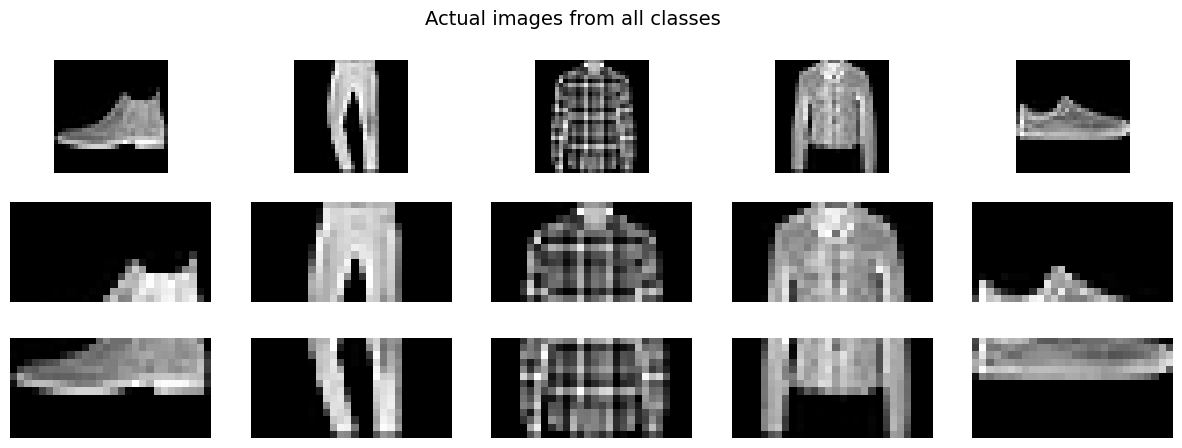

In [22]:
count = 0
print("Predictions of each class:\n")
print(f"{'count':<5} {'Correct Class':<15} {'Top Class':<15} {'Bottom Class':<15}")
print("-" * 50)
indices = []
for i in range(len(x_test)):
    if (y_test[i] == y_pred_top[i]) & (y_test[i] != y_pred_bottom[i]) | (y_test[i] != y_pred_top[i]) & (y_test[i] == y_pred_bottom[i]):
        count += 1
        print(f"{count:<5} {class_names[y_test[i]]:<15} {class_names[y_pred_top[i]]:<15} {class_names[y_pred_bottom[i]]:<15}")
        indices.append(i)
        if count == 5:
            break

fig, axes = plt.subplots(3, 5, figsize=(15, 5))
fig.suptitle("Actual images from all classes", fontsize=14)

for i, ind in enumerate(indices):
    ax = axes[0, i]
    ax.imshow(x_test[ind], cmap="gray")
    ax.axis("off")
    ax = axes[1, i]
    ax.imshow(x_test_top[ind], cmap="gray")
    ax.axis("off")
    ax = axes[2, i]
    ax.imshow(x_test_bottom[ind], cmap="gray")
    ax.axis("off")
    
plt.show()


